# EdgeCameras.jl: Edge Cameras in Julia

This project consists of an implementation of *edge cameras* based on the work of Bouman et al. [1]. An edge camera is formed when a sharp edge (such as the corner of a wall) creates a natural one-dimensonal pinhole camera, revealing the motions of objects which are completely obscured by the corner. More information from the original authors can be found at [people.csail.mit.edu](https://people.csail.mit.edu/klbouman/cornercameras.html). 

This package consists of an entirely new implementation of the edge camera algorithm, based on the work presented in the paper, and done entirely in [Julia](https://julialang.org/) (except for the raw video I/O, which is ultimately handled by `ffmpeg`).

[1] Katherine L. Bouman, Vickie Ye, Gregory W. Wornell, Adam B. Yedidia, Antonio Torralba, William T. Freeman, and Frédo Durand. "Turning Corners into Cameras: Principles and Methods". ICCV 2017.


# Basic Usage

In [1]:
# Optional:
#
# Tell Julia to use the package environment
# contained in this folder. 
# This will give you exactly the same set of 
# Julia packages that were used to make this 
# demo. 
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

 Activating environment at `~/Projects/EdgeCameras.jl/notebooks/Project.toml`


In [2]:
# Make sure the example videos have been downloaded from 
# https://people.csail.mit.edu/klbouman/pw/projects/cornercam/code.html
#
# This will take some time (the dataset is pretty big) the first
# time you call it, but the data will be cached on disk afterwards.
using DataDeps
include("data_dependencies.jl")
video_file = datadep"bouman_edge_cameras_data/example_videos/indoors/loc1_two_people_walking.MOV";

In [3]:
# Load the required modules:
using VideoIO: openvideo
using EdgeCameras: StaticSource, VideoStatistics, Params, EdgeCamera, reconstruct
using Images: imadjustintensity
using Unitful
using AxisArrays: (..)

In [4]:
video = openvideo(video_file)

VideoReader(...)

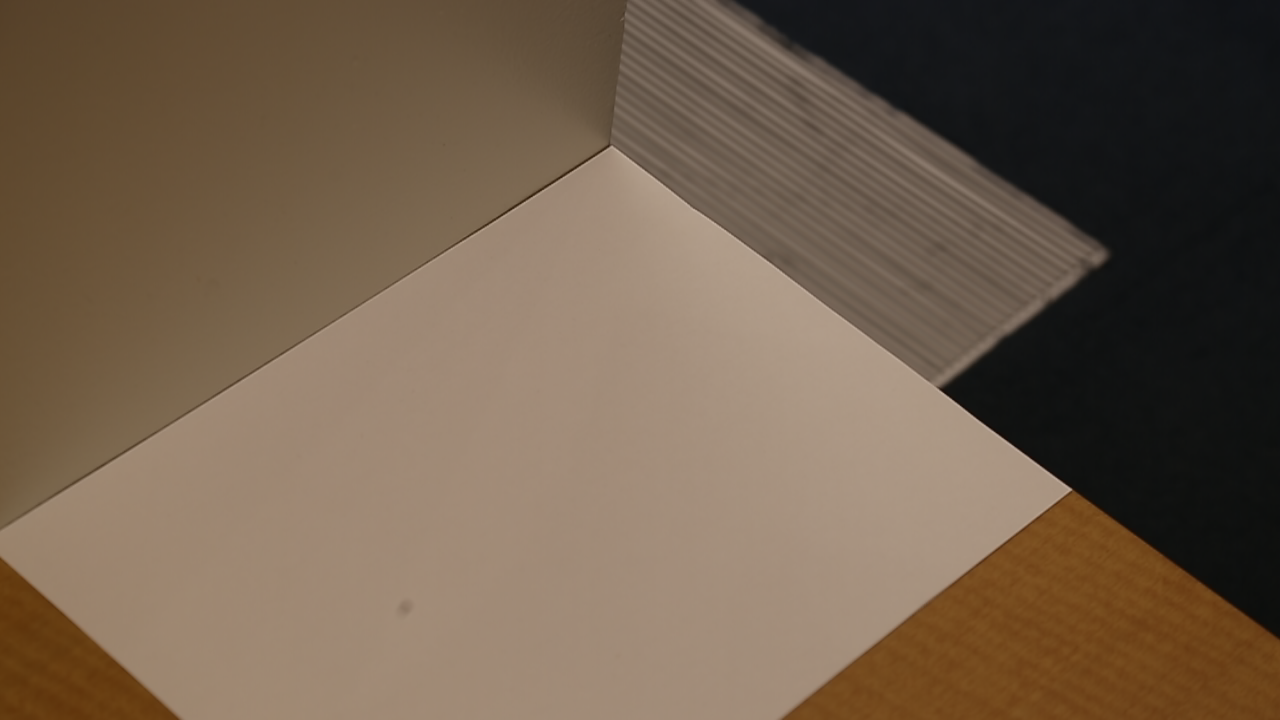

In [5]:
# Extract the background and variance over several frames. This call
# takes the mean and variance over frames from 1 second to 20 seconds, 
# sampling 6 frames per second:
stats = VideoStatistics(video, (1u"s", 20u"s"), 6/u"s")

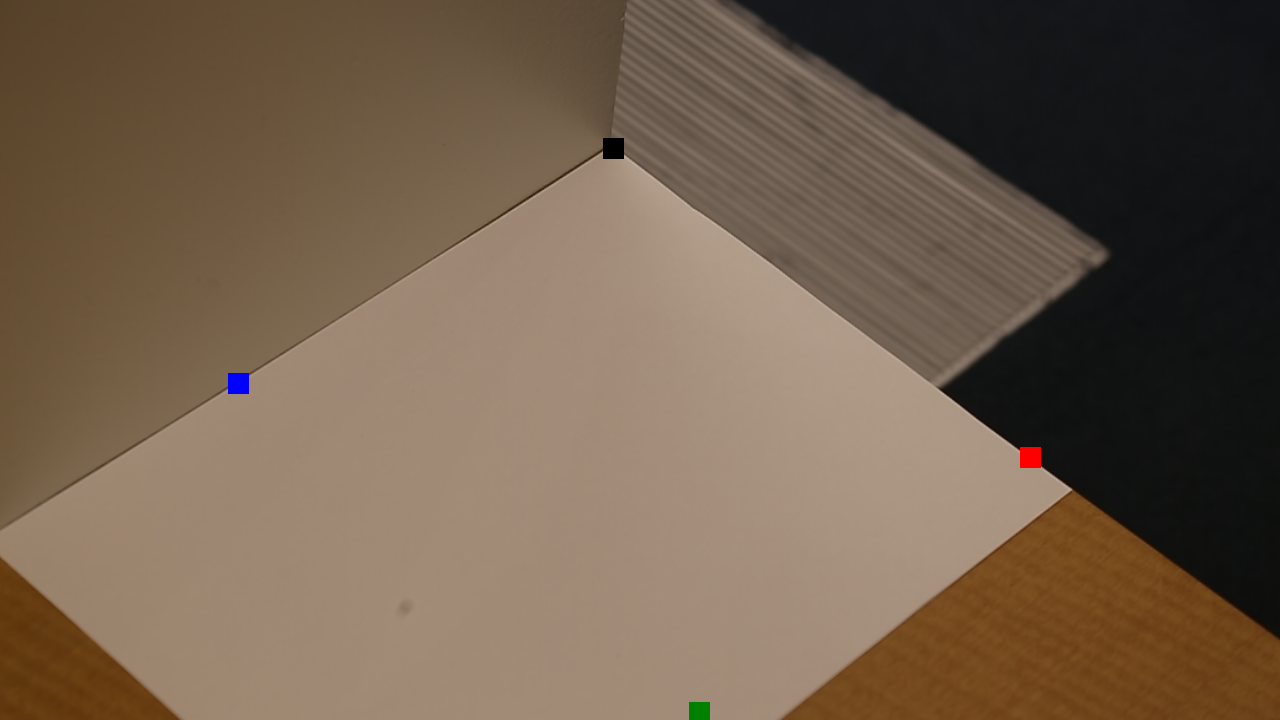

In [6]:
# Specify the corners of a square region around the edge of the wall you're 
# using as a camera. These are pixel coordinates, with the first point (black) 
# at the location of the bottom corner of the wall, and the remaining points
# arranged in the order shown by the red, green, and blue points
corners = [[149, 614], 
    [458, 1031], 
    [713, 700], 
    [384, 239]]

# Construct a source which will remember the background and corners
source = StaticSource(video, corners, stats)

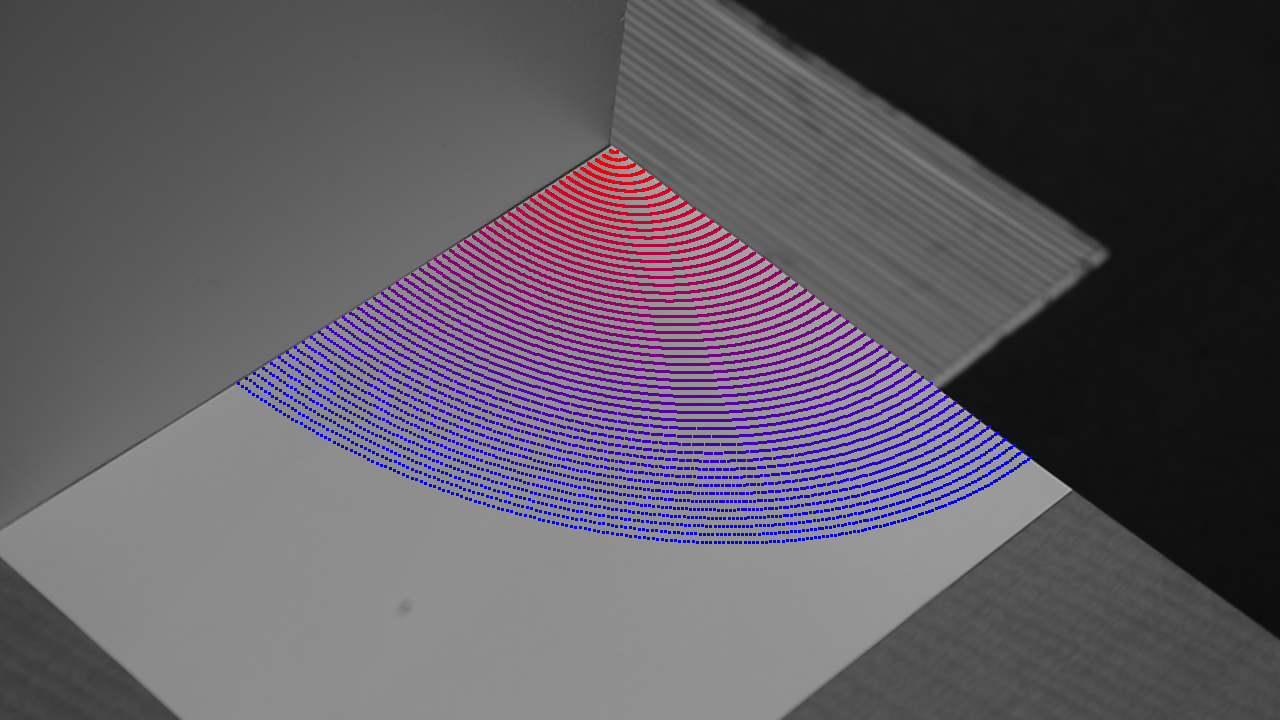

In [7]:
# Create an edge camera using the default parameters. 
# When an EdgeCamera is displayed in IJulia, it will 
# show its radially spaced samples
cam = EdgeCamera(source, Params())

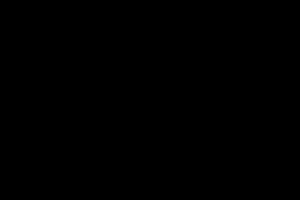

In [8]:
# Reconstruct the 1-D video from the edge camera data.
# This syntax means to reconstruct data from 0 seconds
# to 30 seconds at a frame rate of 10 frames per second.
trace = reconstruct(cam, (0u"s", 30u"s"), 10/u"s")

# The resulting values are extremely small, so just 
# viewing the image normally shows nothing:

┌ Warning: `imadjustintensity` will be removed in a future release, please use `adjust_histogram(img, LinearStretching())` instead.
│   caller = top-level scope at In[9]:1
└ @ Core In[9]:1


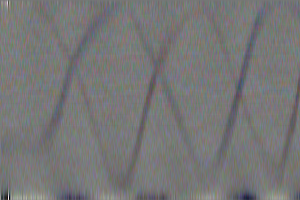

In [9]:
# To see the 1-D video, we just have to normalize the
# result so that all its values are between 0 and 1:
imadjustintensity(trace)

# What's displayed below is a "space-time" image. Each
# column in the image comes from a single frame in the 
# video, and each row corresponds to a single angle of
# view in the hidden scene. 
# Note the two sets of lines, one blue and one red, 
# indicating the motion of the two people in the 
# hidden scene (one wearing blue and one wearing red).
# As you read across the image from left to right, 
# you can see the two people move around relative to
# the edge we're using as a camera.

┌ Warning: `imadjustintensity` will be removed in a future release, please use `adjust_histogram(img, LinearStretching())` instead.
│   caller = top-level scope at In[10]:1
└ @ Core In[10]:1


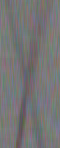

In [10]:
# The result of `reconstruct()` is actually an AxisArray
# from https://github.com/JuliaArrays/AxisArrays.jl

# That means that we can index into the resulting image
# by angle and by time using unitful quantities. For 
# example, let's take a slice of angles from 0.2 to π/4
# and times from 13s to 19s:
imadjustintensity(trace)[0.2..π/4, 13u"s"..19u"s"]